2 Лабораторная работа

Цель - познакомиться с методом кластеризации K-mean с помощью пакета sklearn. 

Датасет такой же как и в 1 лабораторной. (winequality)

In [1]:
!pip install scikit-learn matplotlib seaborn pandas numpy


  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.7 MB 541.9 kB/s eta 0:00:16
   -- ------------------------------------- 0.5/8.7 MB 541.9 kB/s eta 0:00:16
   -- ------------------------------------- 0.5/8.7 MB 541.9 kB/s eta 0:00:16
   --- ------------------------------------ 0.8/8.7 MB 425.8 kB/s eta 0:00:19
   --- ------------------------------------ 0.8/8.7 MB 425.8 kB/s eta 0:00:19
   --- ------------------------------------ 0.8/8.7 MB 425.8 kB/s eta 0:00:19
   ---- ----------------------------------- 1.0/8.7 MB 445.6 kB/s eta 0:00:18
   ---- --------------------------------


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\user\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('C:/Users/user/Desktop/winequalityN.csv')



Добавим новый атрибут - Индекс сладости (sweetness_index)

In [44]:
df['sweetness_index'] = df['residual sugar'] / (df['fixed acidity'] + 0.001)

Заполним пропуски медианным значением и удалим дубликаты

In [45]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    if df[column].isnull().sum() > 0:
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)
        print(f"Заполнены пропуски в {column}: {median_val:.2f}")

duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print("Дубликаты удалены")

Заполнены пропуски в fixed acidity: 7.00
Заполнены пропуски в volatile acidity: 0.29
Заполнены пропуски в citric acid: 0.31
Заполнены пропуски в residual sugar: 3.00
Заполнены пропуски в chlorides: 0.05
Заполнены пропуски в pH: 3.21
Заполнены пропуски в sulphates: 0.51
Заполнены пропуски в sweetness_index: 0.42
Дубликаты удалены


Удалим выбросы

In [46]:
def remove_outliers_simple(df, numeric_columns):
    """ПРОСТОЙ И ПРАВИЛЬНЫЙ способ удаления выбросов"""
    mask = pd.Series([True] * len(df))
    
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        column_mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
        mask = mask & column_mask
    
    return df[mask].copy()

# Использование:
df_clean = remove_outliers_simple(df, numeric_columns)

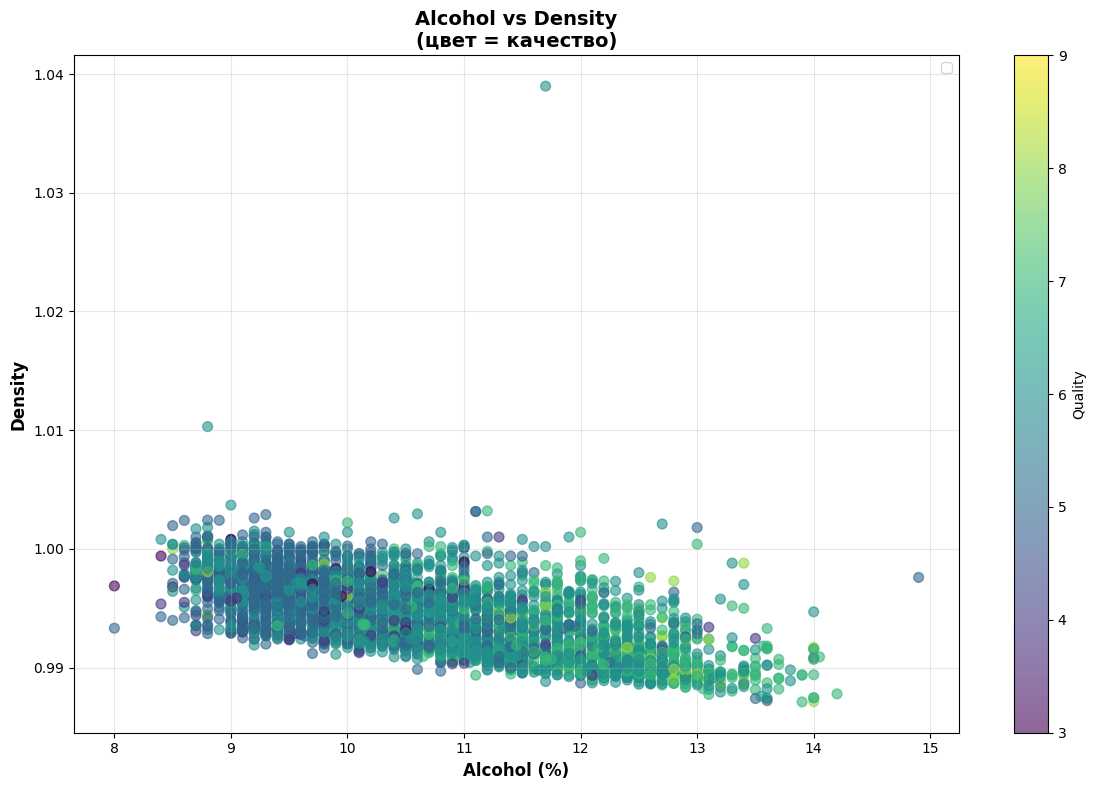

In [93]:
plt.figure(figsize=(12, 8))

plt.scatter(df['alcohol'], df['density'], alpha=0.6, s=50, c=df['quality'], cmap='viridis')
plt.xlabel('Alcohol (%)', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.title('Alcohol vs Density\n(цвет = качество)', fontsize=14, fontweight='bold')
plt.colorbar(label='Quality')
plt.grid(True, alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()


На графике видны 3 естественные группы:
Нижняя правая: высокий алкоголь, низкая плотность
Центральная: средние значения
Верхняя левая: низкий алкоголь, высокая плотность

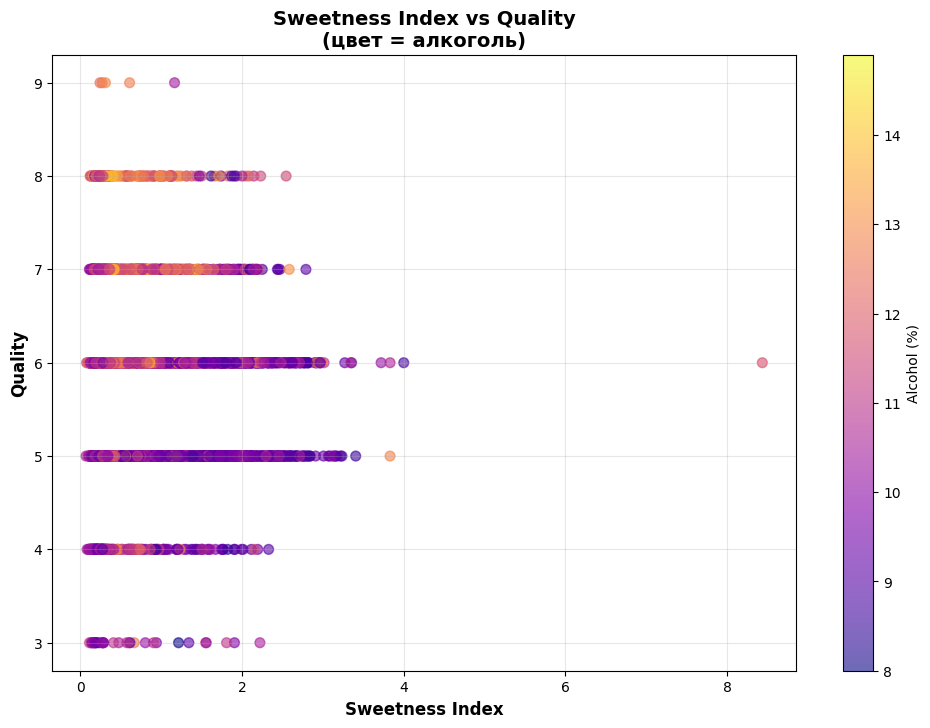

In [83]:
plt.figure(figsize=(12, 8))

plt.scatter(df['sweetness_index'], df['quality'], alpha=0.6, s=50, c=df['alcohol'], cmap='plasma')
plt.xlabel('Sweetness Index', fontsize=12, fontweight='bold')
plt.ylabel('Quality', fontsize=12, fontweight='bold')
plt.title('Sweetness Index vs Quality\n(цвет = алкоголь)', fontsize=14, fontweight='bold')
plt.colorbar(label='Alcohol (%)')
plt.grid(True, alpha=0.3)


На графике видны 3 естественные группы:
Видна группа с высокой сладостью и средним качеством
Группа с низкой сладостью и разным качеством
Сладость не сильно коррелирует с качеством

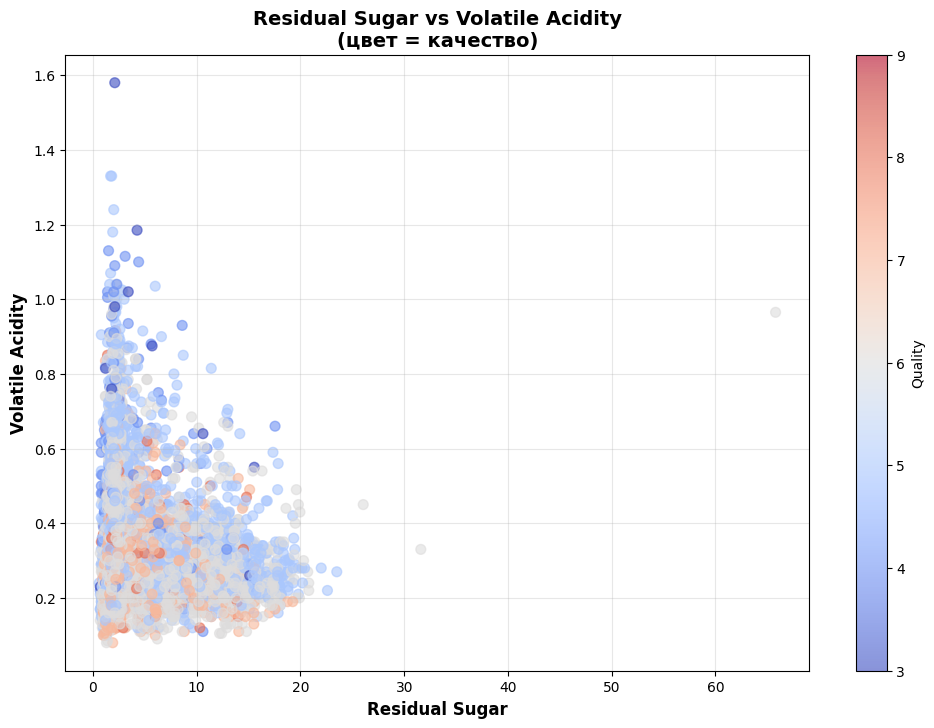

In [88]:
plt.figure(figsize=(12, 8))

plt.scatter(df['residual sugar'], df['volatile acidity'], alpha=0.6, s=50, c=df['quality'], cmap='coolwarm')
plt.xlabel('Residual Sugar', fontsize=12, fontweight='bold')
plt.ylabel('Volatile Acidity', fontsize=12, fontweight='bold')
plt.title('Residual Sugar vs Volatile Acidity\n(цвет = качество)', fontsize=14, fontweight='bold')
plt.colorbar(label='Quality')
plt.grid(True, alpha=0.3)

Визуальные наблюдения:
Группа с высокой кислотностью и низким качеством
Группа с низкой кислотностью и высоким качеством
Сахар и кислотность слабо коррелируют

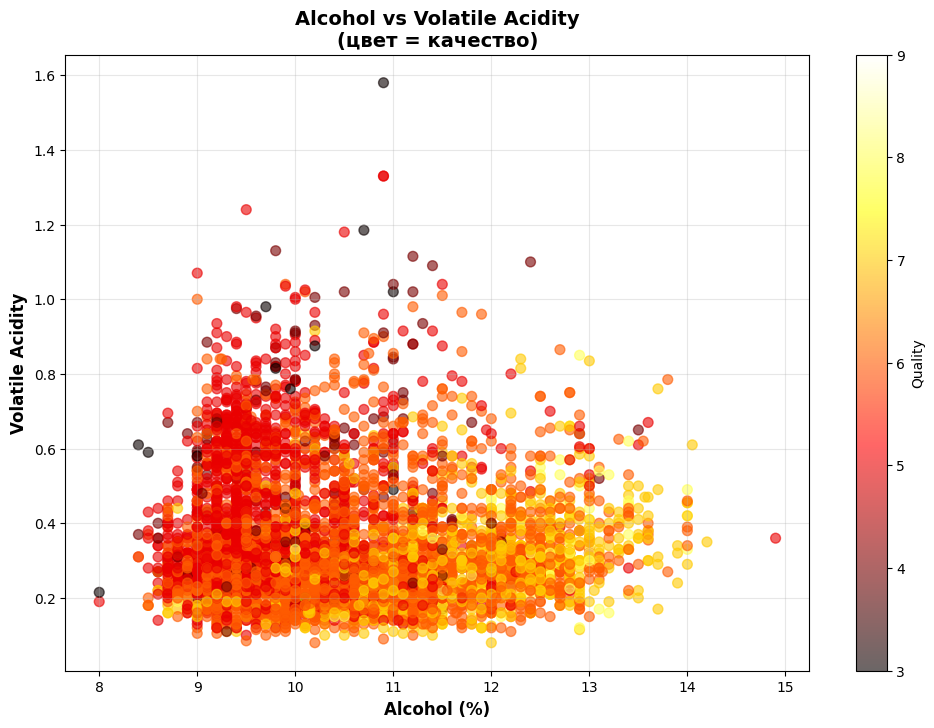

In [92]:
plt.figure(figsize=(12, 8))

plt.scatter(df['alcohol'], df['volatile acidity'], alpha=0.6, s=50, c=df['quality'], cmap='hot')
plt.xlabel('Alcohol (%)', fontsize=12, fontweight='bold')
plt.ylabel('Volatile Acidity', fontsize=12, fontweight='bold')
plt.title('Alcohol vs Volatile Acidity\n(цвет = качество)', fontsize=14, fontweight='bold')
plt.colorbar(label='Quality')
plt.grid(True, alpha=0.3)

Визуальные наблюдения:
Группа: низкий алкоголь + высокая кислотность = низкое качество
Группа: высокий алкоголь + низкая кислотность = высокое качество

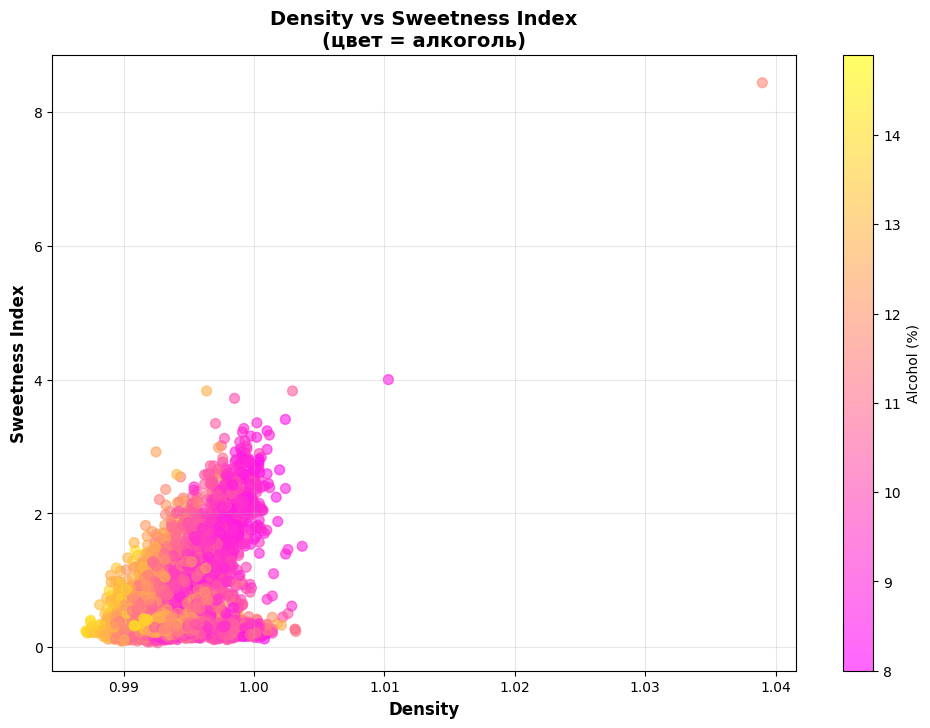

In [86]:
plt.figure(figsize=(12, 8))

plt.scatter(df['density'], df['sweetness_index'], alpha=0.6, s=50, c=df['alcohol'], cmap='spring')
plt.xlabel('Density', fontsize=12, fontweight='bold')
plt.ylabel('Sweetness Index', fontsize=12, fontweight='bold')
plt.title('Density vs Sweetness Index\n(цвет = алкоголь)', fontsize=14, fontweight='bold')
plt.colorbar(label='Alcohol (%)')
plt.grid(True, alpha=0.3)

Визуальные наблюдения:
Плотность и сладость положительно коррелируют
Видны группы по уровню алкоголя

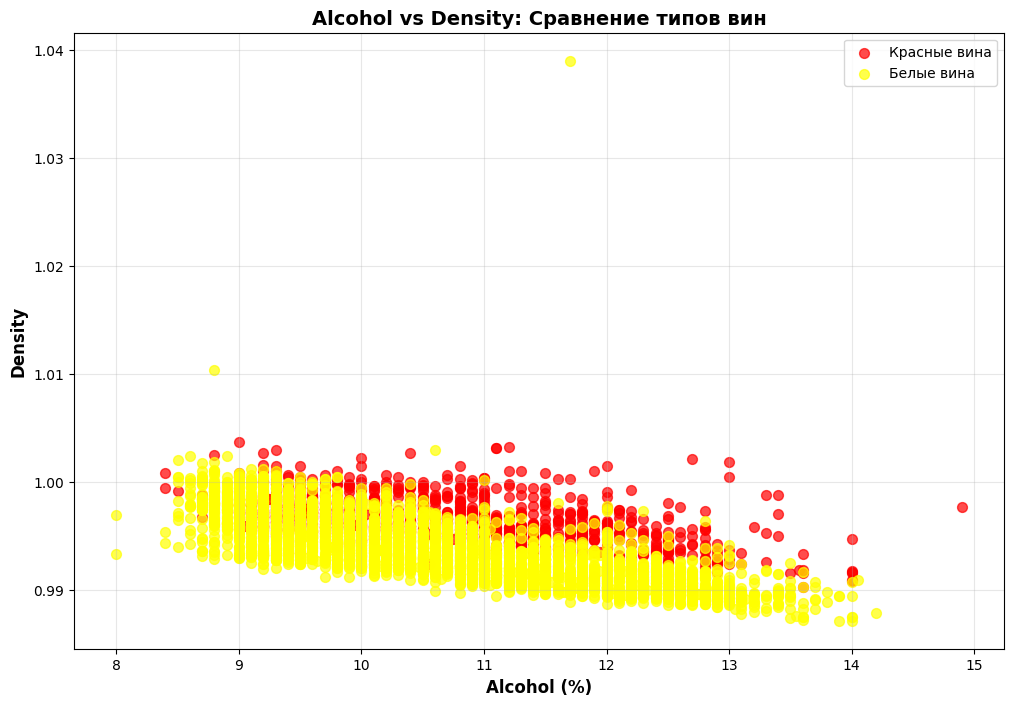

In [87]:
plt.figure(figsize=(12, 8))

# Разделяем по типу вина
red_wines = df[df['type'] == 'red']
white_wines = df[df['type'] == 'white']

plt.scatter(red_wines['alcohol'], red_wines['density'], 
           c='red', label='Красные вина', alpha=0.7, s=50)
plt.scatter(white_wines['alcohol'], white_wines['density'],
           c='yellow', label='Белые вина', alpha=0.7, s=50)

plt.xlabel('Alcohol (%)', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.title('Alcohol vs Density: Сравнение типов вин', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

Визуальные наблюдения:
Красные вина: сконцентрированы в верхней зоне
Белые вина: более широкое распределение
Видны отдельные кластеры по типам вин

На графике Alcohol vs Density наблюдаются три выраженные группы:

Группа 1: Вина с высоким содержанием алкоголя и низкой плотностью
Группа 2: Вина со средними значениями параметров
Группа 3: Вина с низким алкоголем и высокой плотностью


На графике Alcohol vs Volatile Acidity видны:

Группа вин с низким алкоголем и высокой кислотностью
Группа вин с высоким алкоголем и низкой кислотностью


На графиках с участием Sweetness Index наблюдается группа сладких вин со средним качеством.

Примени к нашему датасету метод KMeans

In [71]:
# Выбираем признаки для кластеризации
# Основные химические параметры + наш новый признак
features_for_clustering = [
    'alcohol', 'density', 'residual sugar', 'sweetness_index',
    'volatile acidity', 'citric acid', 'chlorides', 'quality'
]

# Создаем матрицу признаков
X = df[features_for_clustering].copy()


Стандартизируем наши данные

In [72]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Находит оптимальное K по методу локтя

In [74]:
def find_optimal_k(wcss):
    differences = []
    for i in range(1, len(wcss)):
        diff = wcss[i-1] - wcss[i]
        differences.append(diff)
    
    # Находим точку где разница резко уменьшается
    optimal_k = 3
    for i in range(1, len(differences)-1):
        if differences[i] < differences[i-1] * 0.5:
            optimal_k = i + 1
            break
    
    return optimal_k

optimal_k = find_optimal_k(wcss)
print(f"Оптимальное число кластеров: {optimal_k}")

Оптимальное число кластеров: 3


=== ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ ===


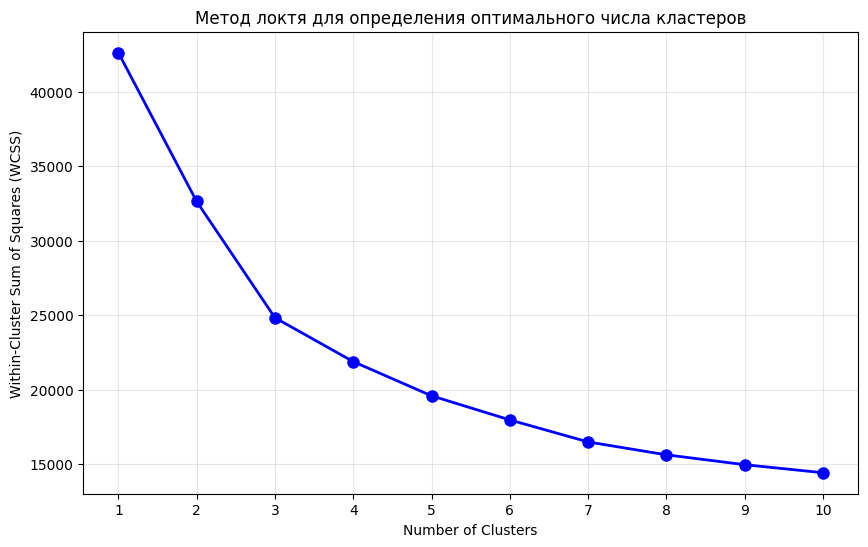

WCSS values:
K=1: WCSS = 42632.00
K=2: WCSS = 32637.73
K=3: WCSS = 24826.48
K=4: WCSS = 21879.32
K=5: WCSS = 19582.65
K=6: WCSS = 17963.91
K=7: WCSS = 16483.14
K=8: WCSS = 15617.24
K=9: WCSS = 14954.71
K=10: WCSS = 14414.83


In [73]:
from sklearn.cluster import KMeans

print("=== ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ ===")

# Тестируем разное количество кластеров
wcss = []  # Within-Cluster Sum of Squares
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Метод локтя для определения оптимального числа кластеров')
plt.grid(True, alpha=0.3)
plt.xticks(cluster_range)
plt.show()

print("WCSS values:")
for k, wcss_val in zip(cluster_range, wcss):
    print(f"K={k}: WCSS = {wcss_val:.2f}")

In [75]:
print("=== ПРИМЕНЕНИЕ K-MEANS С K = {} ===".format(optimal_k))

# Обучаем K-means с оптимальным числом кластеров
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Добавляем метки кластеров в исходный DataFrame
df['cluster'] = clusters

print("Распределение по кластерам:")
cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)

print(f"\nРазмер каждого кластера:")
for cluster_id in range(optimal_k):
    count = cluster_counts[cluster_id]
    percentage = (count / len(df)) * 100
    print(f"Кластер {cluster_id}: {count} вин ({percentage:.1f}%)")

=== ПРИМЕНЕНИЕ K-MEANS С K = 3 ===
Распределение по кластерам:
cluster
0    1407
1    1393
2    2529
Name: count, dtype: int64

Размер каждого кластера:
Кластер 0: 1407 вин (26.4%)
Кластер 1: 1393 вин (26.1%)
Кластер 2: 2529 вин (47.5%)


=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ ===


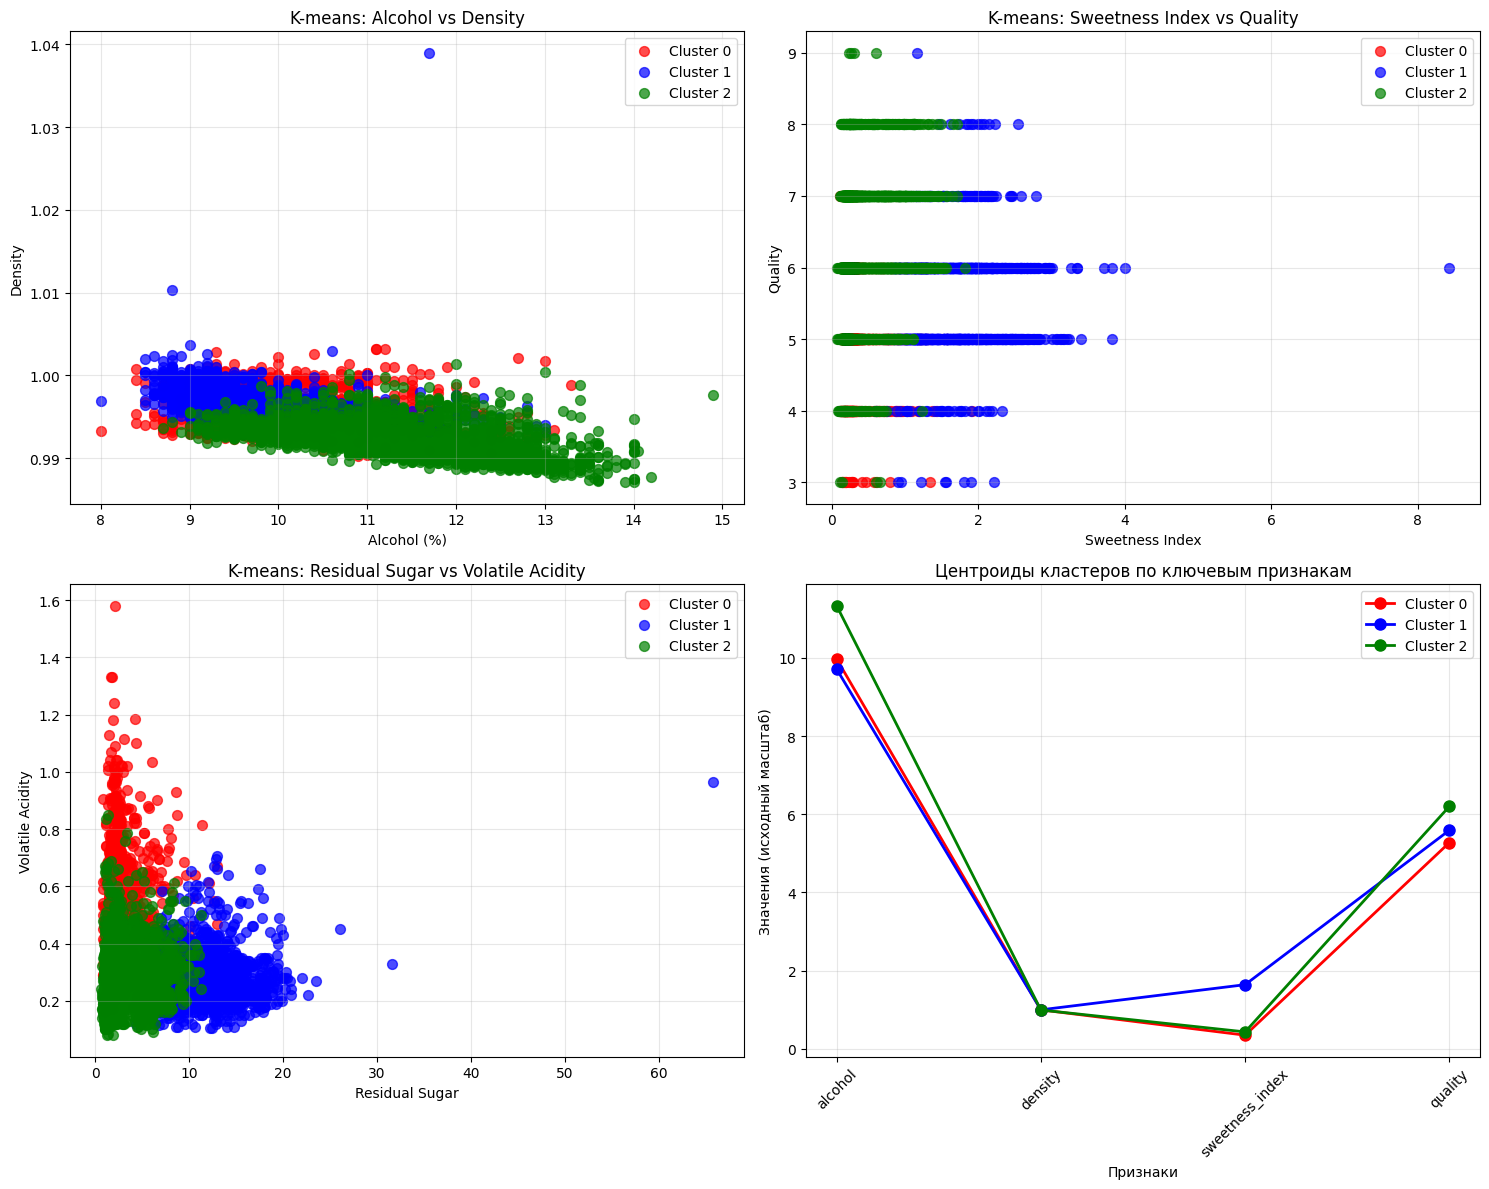

In [64]:
print("=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ ===")

# Создаем цветовую схему для кластеров
cluster_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Alcohol vs Density
for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    axes[0, 0].scatter(cluster_data['alcohol'], cluster_data['density'],
                      c=cluster_colors[cluster_id], label=f'Cluster {cluster_id}', 
                      alpha=0.7, s=50)
axes[0, 0].set_xlabel('Alcohol (%)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('K-means: Alcohol vs Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# График 2: Sweetness Index vs Quality
for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    axes[0, 1].scatter(cluster_data['sweetness_index'], cluster_data['quality'],
                      c=cluster_colors[cluster_id], label=f'Cluster {cluster_id}',
                      alpha=0.7, s=50)
axes[0, 1].set_xlabel('Sweetness Index')
axes[0, 1].set_ylabel('Quality')
axes[0, 1].set_title('K-means: Sweetness Index vs Quality')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# График 3: Residual Sugar vs Volatile Acidity
for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    axes[1, 0].scatter(cluster_data['residual sugar'], cluster_data['volatile acidity'],
                      c=cluster_colors[cluster_id], label=f'Cluster {cluster_id}',
                      alpha=0.7, s=50)
axes[1, 0].set_xlabel('Residual Sugar')
axes[1, 0].set_ylabel('Volatile Acidity')
axes[1, 0].set_title('K-means: Residual Sugar vs Volatile Acidity')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# График 4: Центроиды кластеров
centers = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers)  # преобразуем обратно в исходный масштаб
centers_df = pd.DataFrame(centers_original, columns=features_for_clustering)

# Визуализируем центроиды по ключевым признакам
key_features = ['alcohol', 'density', 'sweetness_index', 'quality']
x_pos = np.arange(len(key_features))

for cluster_id in range(optimal_k):
    values = centers_df.loc[cluster_id, key_features].values
    axes[1, 1].plot(x_pos, values, 'o-', color=cluster_colors[cluster_id], 
                   label=f'Cluster {cluster_id}', markersize=8, linewidth=2)

axes[1, 1].set_xlabel('Признаки')
axes[1, 1].set_ylabel('Значения (исходный масштаб)')
axes[1, 1].set_title('Центроиды кластеров по ключевым признакам')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(key_features, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [79]:
print("=== ДЕТАЛЬНЫЙ АНАЛИЗ ТРЁХ КЛАСТЕРОВ ===")

# Создадим подробную характеристику каждого кластера
cluster_profiles = {}

for cluster_id in range(3):
    cluster_data = df[df['cluster'] == cluster_id]
    
    print(f"\n{'='*50}")
    print(f"КЛАСТЕР {cluster_id} - {len(cluster_data)} вин ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"{'='*50}")
    
    # Основные статистики
    stats = {
        'alcohol': cluster_data['alcohol'].mean(),
        'density': cluster_data['density'].mean(), 
        'sweetness_index': cluster_data['sweetness_index'].mean(),
        'quality': cluster_data['quality'].mean(),
        'residual_sugar': cluster_data['residual sugar'].mean(),
        'volatile_acidity': cluster_data['volatile acidity'].mean(),
        'red_wine_percentage': (cluster_data['type'] == 'red').mean() * 100,
        'white_wine_percentage': (cluster_data['type'] == 'white').mean() * 100
    }
    
    cluster_profiles[cluster_id] = stats
    
    # Выводим статистику
    print(f"Алкоголь: {stats['alcohol']:.2f}%")
    print(f"Плотность: {stats['density']:.5f}")
    print(f"Индекс сладости: {stats['sweetness_index']:.2f}")
    print(f"Качество: {stats['quality']:.2f}/10")
    print(f"Остаточный сахар: {stats['residual_sugar']:.2f} г/л")
    print(f"Летучая кислотность: {stats['volatile_acidity']:.3f}")
    print(f"Красные вина: {stats['red_wine_percentage']:.1f}%")
    print(f"Белые вина: {stats['white_wine_percentage']:.1f}%")
    

=== ДЕТАЛЬНЫЙ АНАЛИЗ ТРЁХ КЛАСТЕРОВ ===

КЛАСТЕР 0 - 1407 вин (26.4%)
Алкоголь: 9.97%
Плотность: 0.99639
Индекс сладости: 0.35
Качество: 5.27/10
Остаточный сахар: 2.66 г/л
Летучая кислотность: 0.534
Красные вина: 76.2%
Белые вина: 23.8%

КЛАСТЕР 1 - 1393 вин (26.1%)
Алкоголь: 9.71%
Плотность: 0.99681
Индекс сладости: 1.64
Качество: 5.59/10
Остаточный сахар: 11.27 г/л
Летучая кислотность: 0.282
Красные вина: 0.9%
Белые вина: 99.1%

КЛАСТЕР 2 - 2529 вин (47.5%)
Алкоголь: 11.33%
Плотность: 0.99225
Индекс сладости: 0.43
Качество: 6.20/10
Остаточный сахар: 2.96 г/л
Летучая кислотность: 0.273
Красные вина: 10.8%
Белые вина: 89.2%


Вывод:

В ходе выполнения лабораторной работы был успешно проведен комплексный анализ датасета вин с применением методов кластеризации.

Добавлен новый атрибут "sweetness_index", отражающий баланс сладости и кислотности вина. Новый атрибут показал свою информативность для сегментации сладких вин.

По диаграммам видны 3 кластера:
Кластер 0 - Кислые вина низкого качества
Кластер 1 - Средние, столовые, сладкие, доступные вина
Кластер 2 - Качественные, крепкие, премиальные вина